In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

models_path="dataset/models/"
scenes_path="dataset/scenes/"

products_B={i:f"{models_path}ref{i}.png" for i in range(15,28)}

scenes_B={i:f"{scenes_path}scene{i}.png" for i in range(6,13)}

In [13]:
img_shapes = {
    6: (1072, 1514),
    7: (766, 1146),
    8: (1014, 1504),
    9: (662, 1488),
    10: (932, 1696),
    11: (674, 1482),
    12: (704, 1626),
}

positions = {
    8: {
        'c': [10, 450, 820, 1160, img_shapes[8][1]],
        'r': [180, img_shapes[8][0]]
    },
    9: {
        'c': [0, 230, 490, 730, 970, 1230, 1470],
        'r': [150, img_shapes[9][0]]
    },
    10: {
        'c': [580, 840, 1120, 1390, 1650],
        'r': [200, 850]
    },
    11: {
        'c': [70, 255, 450, 650, 840, 1035, 1240, 1440],
        'r': [120, 620]
    },
    12: {
        'c': [0, 280, 560, 815, 1070, 1345, 1610],
        'r': [150, 150+570]
    },

}

checks = {
    8: {
        0:[18,26,27],1:[17,23,24],2:[17,23,24],3:[17,23,24]
    },
    9: {
        0:[18,20,26,27],1:[18,20,26,27],2:[18,19,26,27],3:[18,19,26,27],4:[20],5:[20]
    },
    10: {
        0: [21,22,23], 1: [21,22,23], 2: [21,22,23], 3: [21,22,23]
    },
    11: {
        0: [17,23,24], 1: [17,23,24], 2: [17,23,24], 3: [17,23,24],4:[25],5:[25],6:[25]
    },
    12: {
        0:[18,26,27],1:[18,26,27],2:[18,26,27],3:[18,26,27],4:[18,26,27],5:[18,26,27]
    },
}

true = {
    8: {
        0: 27, 1: 23, 2: 23, 3: 24
    },
    9: {
        0: 18, 1: 18, 2: 19, 3: 19, 4: 20, 5: 20
    },
    10: {
        0: 21, 1: 21, 2: 22, 3: 22
    },
    11: {
        0: 23, 1: 23, 2: 24, 3: 24, 4: 25, 5: 25, 6: 25
    },
    12: {
        0: 26, 1: 26, 2: 27, 3: 27, 4: 18, 5: 18
    }
}

In [14]:
product_images={}
for product in products_B:
    product_images[product]=cv2.cvtColor(cv2.imread(products_B[product]), cv2.COLOR_BGR2RGB)

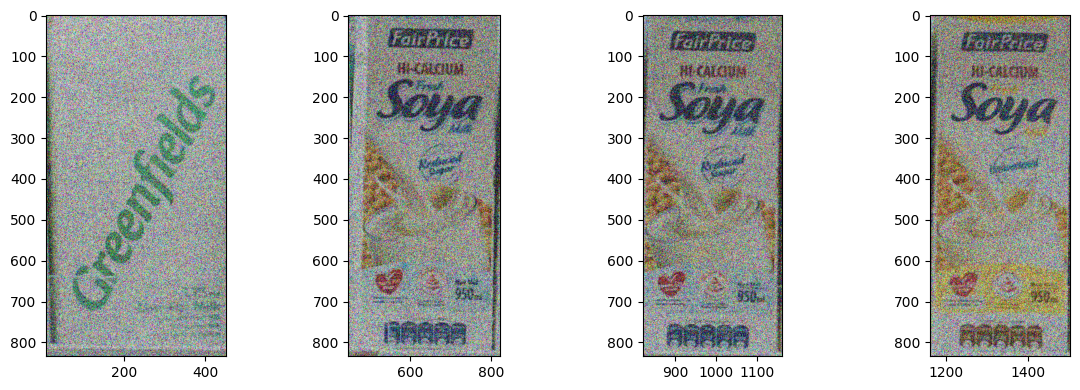

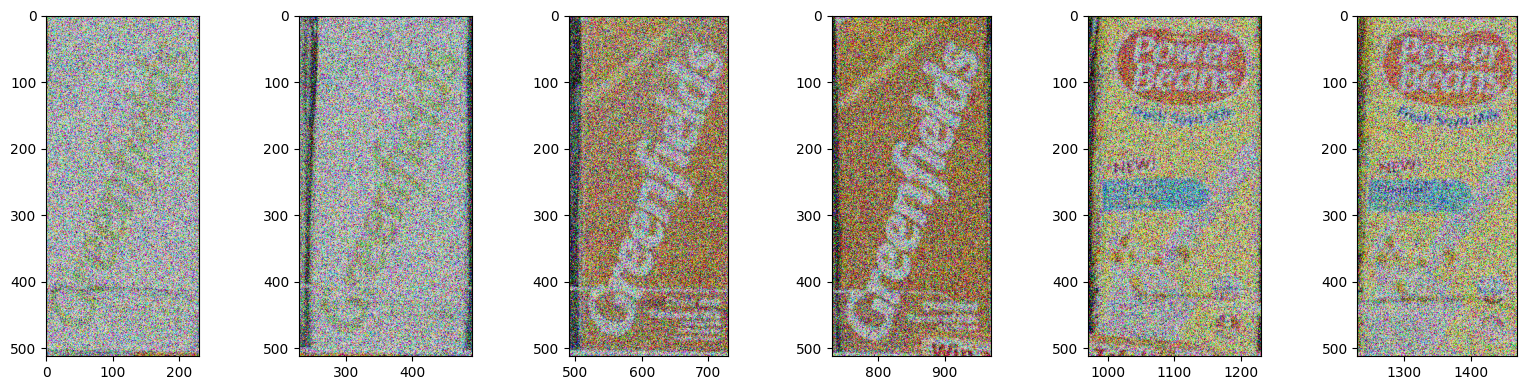

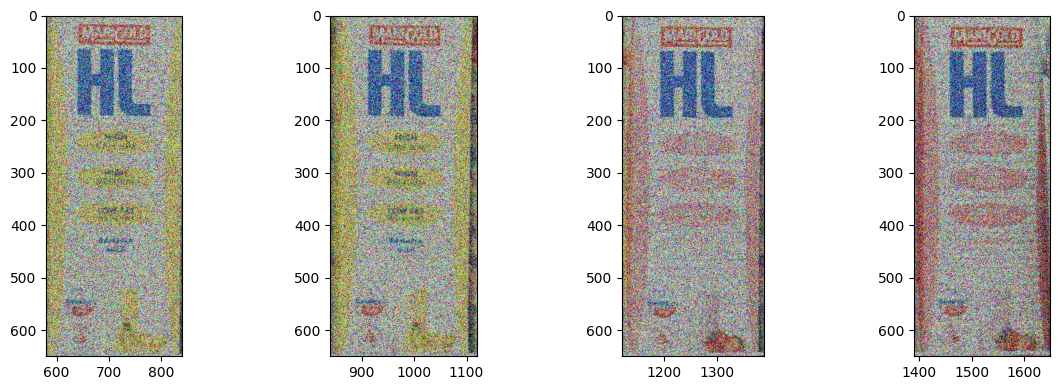

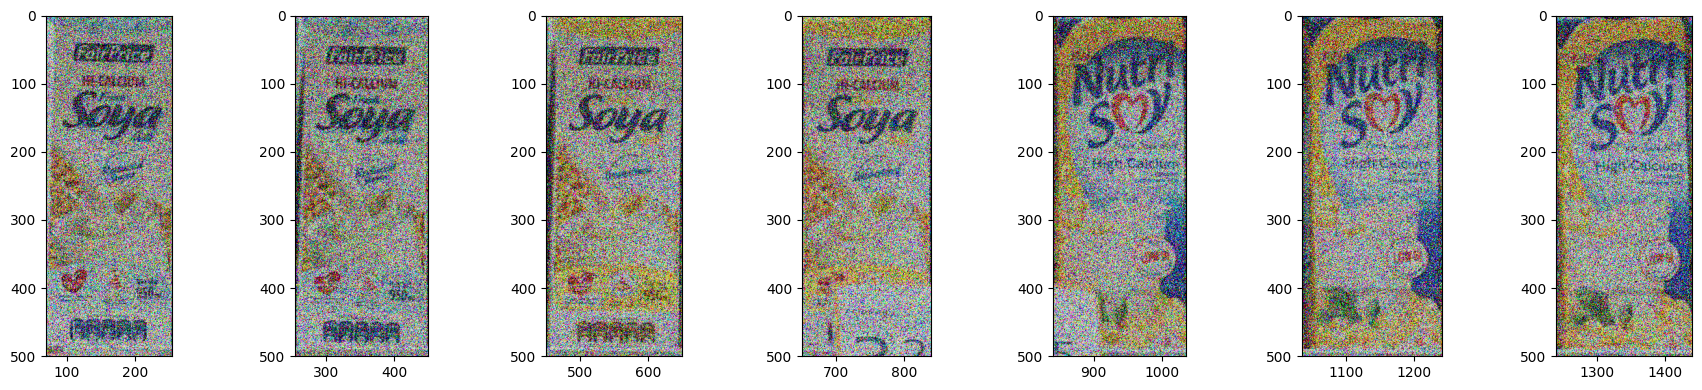

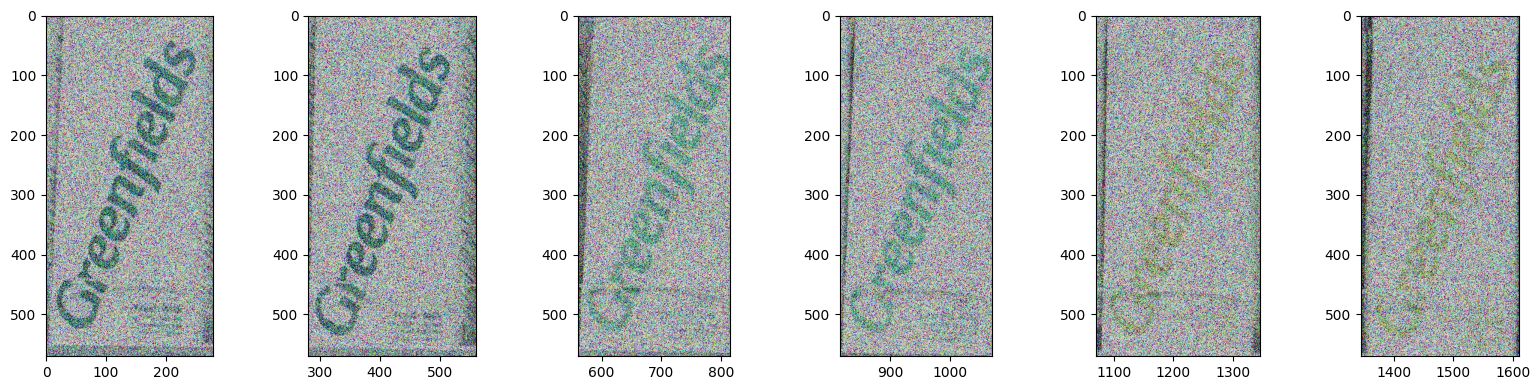

In [15]:
scene_images={}
for scene in positions:
    fig, axes = plt.subplots(1, len(positions[scene]['c'])-1, figsize=(2+2*len(positions[scene]['c']), 4),squeeze=False)
    axes = axes.flatten()

    image=cv2.cvtColor(cv2.imread(scenes_B[scene]), cv2.COLOR_BGR2RGB)
    l=positions[scene]['c'][0]
    r1,r2=positions[scene]['r']
    scene_images[scene]={}
    for i,r in enumerate(positions[scene]['c'][1:]):
        scene_images[scene][i]=image[r1:r2,l:r].copy()
        axes[i].imshow(image[r1:r2,l:r],extent=[l,r,r2-r1,0],aspect='equal')
        l=r

    plt.tight_layout()
    plt.show()

In [16]:
def disturb_image(product,value,type):
    noise=0
    match type:
        case 'randint':
            noise=np.random.randint(-value,value,product_images[product].shape)+value
        case 'normal':
            noise=np.random.normal(scale=value,size=product_images[product].shape)
        case _: 
            return product_images[product]
    return np.clip(product_images[product]-noise,0,225).astype(np.uint8)

In [19]:
def compute_color_similarity(ref, scene):
    sceneR=scene[:,:,0]
    sceneG=scene[:,:,1]
    sceneB=scene[:,:,2]
    sceneR = cv2.resize(sceneR,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    sceneG = cv2.resize(sceneG,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    sceneB = cv2.resize(sceneB,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    scene=np.stack((sceneR,sceneG,sceneB),axis=-1)
    pixel_euclidean = np.linalg.norm(ref - scene)
    pixel_manhattan = np.sum(np.abs(ref - scene))
    pixel_cosine = np.dot(ref.flatten(), scene.flatten()) / (np.linalg.norm(ref) * np.linalg.norm(scene))
    
    # Compute histogram comparison metrics
    hist1 = cv2.calcHist([ref], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([scene], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    hist_chi_squared = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    hist_bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    
    # Print results
    # print("Pixel-wise Comparison:")
    # print("Euclidean distance:", pixel_euclidean)
    # print("Manhattan distance:", pixel_manhattan)
    # print("Cosine similarity:", pixel_cosine)
    # print("\nHistogram Comparison:")
    # print("Histogram Intersection:", hist_intersection)
    # print("Chi-Squared distance:", hist_chi_squared)
    # print("Bhattacharyya distance:", hist_bhattacharyya)
    return pixel_euclidean,pixel_manhattan,pixel_cosine,hist_intersection,hist_chi_squared,hist_bhattacharyya

In [20]:
VALUE=75
res={}
for scene in scene_images:
    res[scene]={}
    for i,slice in enumerate(scene_images[scene]):
        res[scene][i]={}
        # print(scene_images[scene][slice].shape)
        # mean_slice=np.mean(scene_images[scene][slice])
        for product in checks[scene][i]:
            # print(scene,i,product)
            # noisy=disturb_image(product,VALUE,'normal')
            # mean_noisy_product=np.mean(noisy)
            res[scene][i][product]=compute_color_similarity(product_images[product],scene_images[scene][i])


In [30]:
display(res)

{8: {0: {18: (129924.43055099375,
    124881734,
    4.790606487201203e-09,
    48375.0,
    49924524.16807945,
    0.8894384492774051),
   26: (127341.50162849503,
    118783141,
    1.8845230082887818e-10,
    43107.0,
    40637500.23256236,
    0.9009427280660323),
   27: (130211.5027292136,
    126293255,
    2.4783104580447025e-09,
    63980.0,
    32463636.357763745,
    0.879722142143243)},
  1: {17: (130395.5052024417,
    97844201,
    3.250994266566669e-09,
    78277.0,
    4356008.309921359,
    0.6989737386004212),
   23: (147928.78986863917,
    125345408,
    4.783728152757873e-09,
    99147.0,
    9910090.6404051,
    0.7039928515959868),
   24: (144126.7645685561,
    121770365,
    3.983059877602527e-09,
    88203.0,
    17807672.040933263,
    0.7111441426552383)},
  2: {17: (127526.18796937357,
    94731698,
    4.337058726798602e-09,
    76589.0,
    4290165.293883795,
    0.706361827008678),
   23: (144835.87144074496,
    121833952,
    2.8361412810302286e-09,
   

In [32]:
num_metrics=6
for scene in res:
    print(f'scene {scene}:')
    for slice in res[scene]:
        print(f'\tslice {slice}:')
        for i in range(1,6):
            vals=[res[scene][slice][product][i] for product in res[scene][slice]]
            min_value = min(vals)
            min_index = vals.index(min_value)
            keys=list(res[scene][slice].keys())
            print(f'\t\tmetric No:{i}, best prod:{keys[min_index]}')


scene 8:
	slice 0:
		metric No:1, best prod:26
		metric No:2, best prod:26
		metric No:3, best prod:26
		metric No:4, best prod:27
		metric No:5, best prod:27
	slice 1:
		metric No:1, best prod:17
		metric No:2, best prod:17
		metric No:3, best prod:17
		metric No:4, best prod:17
		metric No:5, best prod:17
	slice 2:
		metric No:1, best prod:17
		metric No:2, best prod:23
		metric No:3, best prod:17
		metric No:4, best prod:17
		metric No:5, best prod:17
	slice 3:
		metric No:1, best prod:17
		metric No:2, best prod:24
		metric No:3, best prod:17
		metric No:4, best prod:17
		metric No:5, best prod:24
scene 9:
	slice 0:
		metric No:1, best prod:26
		metric No:2, best prod:27
		metric No:3, best prod:26
		metric No:4, best prod:20
		metric No:5, best prod:20
	slice 1:
		metric No:1, best prod:26
		metric No:2, best prod:27
		metric No:3, best prod:26
		metric No:4, best prod:20
		metric No:5, best prod:20
	slice 2:
		metric No:1, best prod:26
		metric No:2, best prod:27
		metric No:3, b

In [22]:
def check_smallest(res):
    for scene in res:
        print(f'scene {scene}')
        for index, data in res[scene].items():
            smallest_key = min(data.keys(), key=lambda k: data[k])
            print(f"product {index+1}, best color: {smallest_key} ({res[scene][index][smallest_key]:.3f})")

check_smallest(res)

scene 8


TypeError: unsupported format string passed to tuple.__format__